## Influence of AI as perceived by the Stackoverflow users during the last years

I want to analyze how AI has shaped the Stackoverflow surveys during the last years and how the users perceived it.

### Loading libraries and data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import math
from collections import defaultdict, Counter
from typing import Optional, Dict, List, Tuple
import unicodedata
%matplotlib inline

pd.set_option('display.max_colwidth', None)

In [2]:
def load_stackoverflow_data(folder_path, load_schema=False):
    """
    Load Stack Overflow survey or schema CSV files from a folder into a dictionary of DataFrames.
    
    Parameters:
        folder_path (str): Path to the folder containing CSV files.
        load_schema (bool): If True, load schema files (filenames containing 'schema').
                            If False, load survey response files.
    
    Returns:
        dict: { 'survey_<year>': DataFrame }
    """
    # Determine filter based on schema flag
    if load_schema:
        csv_files = [f for f in glob.glob(os.path.join(folder_path, "*.csv")) if "schema" in os.path.basename(f).lower()]
    else:
        csv_files = [f for f in glob.glob(os.path.join(folder_path, "*.csv")) if "schema" not in os.path.basename(f).lower()]

    data_dict = {}

    for file in csv_files:
        filename = os.path.basename(file)
        
        # Extract year from filename
        match = re.search(r"(20)\d{2}", filename)
        year = int(match.group()) if match else None
        
        # Read CSV with encoding fallback
        try:
            df = pd.read_csv(file, encoding="utf-8")
        except UnicodeDecodeError:
            df = pd.read_csv(file, encoding="latin1")
        
        # Add Year column
        df["Year"] = year
        
        # Create dictionary key
        key_name = f"survey_{year}" if year else "survey_unknown"
        data_dict[key_name] = df

    return data_dict


In [3]:
schema_dfs = load_stackoverflow_data(folder_path="data", load_schema=True)
survey_dfs = load_stackoverflow_data(folder_path="data", load_schema=False)

C:\Users\UUJI17D\AppData\Local\Temp\1\ipykernel_7908\3535547984.py:30: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding="utf-8")


In [4]:
survey_dfs.keys()

dict_keys(['survey_2017', 'survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025'])

In [5]:
schema_dfs.keys()

dict_keys(['survey_2017', 'survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025'])

### Definition of helper functions for data assessment

In [6]:
def find_common_columns(df_set):
    """
    Find columns that appear in at least two DataFrames and show which surveys they belong to.
    Sorted by frequency (descending).

    Args:
        df_set (dict): Dictionary of DataFrames {survey_name: DataFrame}

    Returns:
        list of tuples: [(column_name, count, [surveys]), ...] sorted by count desc
    """
    # Map each column to the surveys it appears in
    column_map = defaultdict(list)
    for survey_name, df in df_set.items():
        for col in df.columns:
            column_map[col].append(survey_name)

    # Keep only columns that appear in at least two surveys
    common_columns = {col: surveys for col, surveys in column_map.items() if len(surveys) >= 2}

    # Sort by frequency
    common_sorted = sorted(
        [(col, len(surveys), surveys) for col, surveys in common_columns.items()],
        key=lambda x: x[1],
        reverse=True
    )

    # Print results
    print("Columns common to at least two surveys (sorted by frequency):")
    for col, count, surveys in common_sorted:
        print(f"{col} ({count} surveys): {surveys}")

    return common_sorted

In [7]:
def find_unique_columns(df_set):
    """
    Find columns that are unique to a single survey, list them by survey, and provide a summary count.

    Args:
        df_set (dict): Dictionary of DataFrames {survey_name: DataFrame}

    Returns:
        dict: {survey: [unique_columns]}
    """
    
    # Map each column to the surveys it appears in
    column_map = defaultdict(list)
    for survey_name, df in df_set.items():
        for col in df.columns:
            column_map[col].append(survey_name)

    # Filter unique columns
    unique_columns = {col: surveys for col, surveys in column_map.items() if len(surveys) == 1}

    # Organize by survey
    survey_unique_map = defaultdict(list)
    for col, surveys in unique_columns.items():
        survey_unique_map[surveys[0]].append(col)

    # Sort surveys alphabetically and columns inside each survey
    survey_unique_map = {survey: sorted(cols) for survey, cols in sorted(survey_unique_map.items())}

    # Print results
    print("Unique columns per survey:")
    for survey, cols in survey_unique_map.items():
        print(f"{survey} ({len(cols)} unique columns): {cols}")

    return survey_unique_map

In [8]:
def find_questions_by_keyword(schema_dfs, keyword,
                               col_name_cols=("Column", "qname"),
                               question_cols=("question", "QuestionText", "Question"),
                               case=True, verbose=True):
    """
    Find all questions containing a given keyword AND a question mark across multiple schema DataFrames.

    Parameters:
        schema_dfs (dict): {survey_name: DataFrame}
        keyword (str): keyword to search for
        col_name_cols (tuple): possible column name fields
        question_cols (tuple): possible question text fields
        case (bool): case-sensitive search (default False)
        verbose (bool): if True, prints grouped results

    Returns:
        DataFrame: ['survey', 'column_name', 'question']
    """
    
    rows = []
    pattern = f"(?=.*{re.escape(keyword)})(?=.*[?？])"  # keyword + question mark

    for survey_name, schema in schema_dfs.items():
        col_name_col = next((c for c in col_name_cols if c in schema.columns), None)
        q_col = next((c for c in question_cols if c in schema.columns), None)
        if not col_name_col or not q_col:
            continue

        mask = schema[q_col].astype(str).str.contains(pattern, case=case, na=False, regex=True)
        matches = schema.loc[mask, [col_name_col, q_col]].copy()
        if not matches.empty:
            matches["survey"] = survey_name
            matches.rename(columns={col_name_col: "column_name", q_col: "question"}, inplace=True)
            rows.append(matches)

    if not rows:
        if verbose:
            print(f"No matches found for keyword '{keyword}' with a question mark.")
        return pd.DataFrame(columns=["survey", "column_name", "question"])

    df = pd.concat(rows, ignore_index=True)

    if verbose:
        print(f"Found {len(df)} matches for keyword '{keyword}':")
        for survey in df["survey"].unique():
            print(f"\n--- {survey} ---")
            subset = df[df["survey"] == survey]
            for _, row in subset.iterrows():
                print(f"{row['column_name']}: {row['question']}")

    return df


In [9]:
def find_duplicates_across_surveys(df, check_on="question", duplicate_min=2, only_duplicates=True, verbose=True):
    """
    Find duplicates across surveys based on question text OR column_name.

    Parameters:
        df (DataFrame): Output from find_questions_by_keyword or similar
        check_on (str): 'question' or 'column_name' (field to check duplicates on)
        duplicate_min (int): Minimum number of surveys for a duplicate (default 2)
        only_duplicates (bool): If True, return only rows that meet the duplicate_min threshold
        verbose (bool): if True, prints grouped results

    Returns:
        DataFrame: ['survey', 'column_name', 'question', 'survey_count', 'duplicate_flag']
    """
    import pandas as pd
    import re
    import unicodedata

    if df.empty:
        if verbose:
            print("No data to check for duplicates.")
        return pd.DataFrame(columns=["survey", "column_name", "question", "survey_count", "duplicate_flag"])

    # Normalization for grouping
    def normalize(text):
        text = unicodedata.normalize("NFKC", str(text))
        text = text.replace("\u00A0", " ").replace("\u202F", " ")
        text = re.sub(r"[\u200B-\u200D\u2060\uFEFF]", "", text)
        text = text.replace("*", "").replace("＊", "")
        text = re.sub(r"\s+", " ", text.lower()).strip()
        return text

    if check_on not in ["question", "column_name"]:
        raise ValueError("check_on must be 'question' or 'column_name'")

    df = df.copy()
    df["normalized"] = df[check_on].apply(normalize)
    df = df[df["normalized"].ne("")]

    # Count surveys per normalized value
    survey_counts = df.groupby("normalized")["survey"].nunique()
    df["survey_count"] = df["normalized"].map(survey_counts)
    df["duplicate_flag"] = df["survey_count"] >= duplicate_min

    # Filter if only duplicates requested
    if only_duplicates:
        df = df[df["duplicate_flag"]]

    df = df.drop(columns="normalized").sort_values(
        by=["duplicate_flag", "survey_count", "survey"], ascending=[False, False, True]
    ).reset_index(drop=True)

    if verbose and not df.empty:
        print(f"Duplicates based on {check_on} (min surveys = {duplicate_min}):")
        for survey in df["survey"].unique():
            print(f"\n--- {survey} ---")
            subset = df[df["survey"] == survey]
            for _, row in subset.iterrows():
                marker = f" (DUPLICATE, {row['survey_count']})" if row['survey_count'] >= duplicate_min else ""
                print(f"{row['column_name']}: {row['question']}{marker}")
    elif verbose:
        print("No duplicates found.")

    return df


In [10]:
def get_description(column_name, schema_dfs,
                    col_name_cols=("Column", "qname"),
                    question_cols=("question", "QuestionText", "Question"),
                    return_all=True):
    """
    Retrieve the description of a column from multiple schema DataFrames.

    Parameters:
        column_name (str): The name of the column you want to look up.
        schema_dfs (dict): {survey_name: DataFrame} of schema tables.
        col_name_cols (tuple): Possible column names that identify the column name in the schema.
        question_cols (tuple): Possible column names that contain the question text.
        return_all (bool): If True, return all matches as a dict {survey: description}. 
                           If False, return the first match.

    Returns:
        str or dict: The description of the column (first match) or a dict of all matches.
    """
    
    results = {}

    for survey_name, schema in schema_dfs.items():
        # Find which column in schema holds the column names
        col_name_col = next((c for c in col_name_cols if c in schema.columns), None)
        if not col_name_col:
            continue

        # Find which column in schema holds the question text
        q_col = next((c for c in question_cols if c in schema.columns), None)
        if not q_col:
            continue

        # Filter for the requested column_name
        match = schema.loc[schema[col_name_col] == column_name, q_col]

        if not match.empty:
            results[survey_name] = match.iloc[0]
            if not return_all:
                return match.iloc[0]

    return results if results else None


In [11]:
def get_column_name(question_text, schema_dfs,
                    col_name_cols=("Column", "qname"),
                    question_cols=("question", "QuestionText", "Question"),
                    case=False, return_all=True):
    """
    Find column name(s) for a given question text from multiple schema DataFrames.
    Handles case-insensitive and partial matches, and escapes regex characters.

    Parameters:
        question_text (str): The question text (or part of it) to search for.
        schema_dfs (dict): {survey_name: DataFrame} of schema tables.
        col_name_cols (tuple): Possible column name fields in schema.
        question_cols (tuple): Possible question text fields in schema.
        case (bool): Case-sensitive search (default False).
        return_all (bool): If True, return all matches as {survey: [columns]}.
                           If False, return the first match found.

    Returns:
        dict or str or None
    """
    results = {}

    # Normalize query: collapse whitespace and lowercase if case=False
    query = " ".join(question_text.split())
    if not case:
        query = query.lower()

    for survey_name, schema in schema_dfs.items():
        # Detect relevant columns
        col_name_col = next((c for c in col_name_cols if c in schema.columns), None)
        q_col = next((c for c in question_cols if c in schema.columns), None)
        if not col_name_col or not q_col:
            continue

        # Normalize schema question text
        q_series = schema[q_col].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
        if not case:
            q_series = q_series.str.lower()

        # Escape regex special chars in query for literal match
        pattern = re.escape(query)

        mask = q_series.str.contains(pattern, na=False)
        matches = schema.loc[mask, col_name_col]

        if not matches.empty:
            results[survey_name] = matches.tolist()
            if not return_all:
                return matches.iloc[0]

    return results if results else None


In [12]:
def value_counts_all_surveys(survey_dfs, column_name, normalize=False, dropna=True, verbose=False):
    """
    Compute value counts for a given column across all surveys, with optional verbose output.

    Parameters:
        survey_dfs (dict): {survey_name: DataFrame}
        column_name (str): Column to compute value counts for
        normalize (bool): If True, return relative frequencies (like pandas normalize)
        dropna (bool): If True, exclude NaN values
        verbose (bool): If True, print detailed info for each survey

    Returns:
        dict: {survey_name: Series of value counts}
    """
    results = {}

    for survey_name, df in survey_dfs.items():
        if column_name in df.columns:
            counts = df[column_name].value_counts(normalize=normalize, dropna=dropna)
            results[survey_name] = counts

            if verbose:
                print(f"\n--- Survey: {survey_name} ---")
                print(f"Column analyzed: {column_name}")
                print(f"Total rows: {len(df)}")
                print(f"Unique values: {df[column_name].nunique(dropna=dropna)}")
                print("Value counts:")
                print(counts.to_string())  # Full output without truncation
        else:
            results[survey_name] = None
            if verbose:
                print(f"\n--- Survey: {survey_name} ---")
                print(f"Column '{column_name}' not found in this survey.")

    return results

### Data assessment

In [13]:
survey_common_cols = find_common_columns(survey_dfs)

Columns common to at least two surveys (sorted by frequency):
Country (9 surveys): ['survey_2017', 'survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
Year (9 surveys): ['survey_2017', 'survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
Employment (8 surveys): ['survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
DevType (8 surveys): ['survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
Age (8 surveys): ['survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
Currency (7 surveys): ['survey_2017', 'survey_2018', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
MainBranch (7 surveys): ['survey_2019', 'survey_2020', 'survey_2021', 'sur

In [14]:
survey_unique_cols = find_unique_columns(survey_dfs)

Unique columns per survey:
survey_2017 (137 unique columns): ['AnnoyingUI', 'AssessJobCommute', 'AssessJobCompensation', 'AssessJobDept', 'AssessJobDiversity', 'AssessJobExp', 'AssessJobFinances', 'AssessJobIndustry', 'AssessJobLeaders', 'AssessJobOffice', 'AssessJobProduct', 'AssessJobProfDevel', 'AssessJobProjects', 'AssessJobRemote', 'AssessJobRole', 'AssessJobTech', 'AuditoryEnvironment', 'BoringDetails', 'BuildingThings', 'ChallengeMyself', 'ChangeWorld', 'ClickyKeys', 'CollaborateRemote', 'CompanyType', 'CompetePeers', 'CousinEducation', 'DeveloperType', 'DifficultCommunication', 'DiversityImportant', 'EducationImportant', 'EmploymentStatus', 'EnjoyDebugging', 'EquipmentSatisfiedCPU', 'EquipmentSatisfiedMonitors', 'EquipmentSatisfiedRAM', 'EquipmentSatisfiedRW', 'EquipmentSatisfiedStorage', 'ExCoder10Years', 'ExCoderActive', 'ExCoderBalance', 'ExCoderBelonged', 'ExCoderNotForMe', 'ExCoderReturn', 'ExCoderSkills', 'ExCoderWillNotCode', 'ExpectedSalary', 'FriendsDevelopers', 'HaveW

In [15]:
schema_common_cols = find_common_columns(schema_dfs)

Columns common to at least two surveys (sorted by frequency):
Year (9 surveys): ['survey_2017', 'survey_2018', 'survey_2019', 'survey_2020', 'survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
qid (5 surveys): ['survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
qname (5 surveys): ['survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
question (5 surveys): ['survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
type (5 surveys): ['survey_2021', 'survey_2022', 'survey_2023', 'survey_2024', 'survey_2025']
Column (4 surveys): ['survey_2017', 'survey_2018', 'survey_2019', 'survey_2020']
force_resp (4 surveys): ['survey_2021', 'survey_2022', 'survey_2023', 'survey_2024']
selector (4 surveys): ['survey_2021', 'survey_2022', 'survey_2023', 'survey_2024']
QuestionText (3 surveys): ['survey_2018', 'survey_2019', 'survey_2020']


In [16]:
schema_unique_cols = find_unique_columns(schema_dfs)

Unique columns per survey:
survey_2017 (1 unique columns): ['Question']
survey_2025 (2 unique columns): ['sq_id', 'sub']


In [17]:
df_matches = find_questions_by_keyword(schema_dfs, "AI")

Found 55 matches for keyword 'AI':

--- survey_2018 ---
AIDangerous: What do you think is the most dangerous aspect of increasingly advanced AI technology?
AIInteresting: What do you think is the most exciting aspect of increasingly advanced AI technology?
AIResponsible: Whose responsibility is it, <u>primarily</u>, to consider the ramifications of increasingly advanced AI technology?

--- survey_2019 ---
PurchaseHow: How does your company make decisions about purchasing new technology (cloud, AI, IoT, databases)?

--- survey_2023 ---
AISearch: Which <b>AI-powered search tools</b> did you use regularly over the past year, and which do you want to work with over the next year? Select all that apply.
AIDev: Which <b>AI-powered developer tools</b> did you use regularly over the past year, and which do you want to work with over the next year? Select all that apply
SOAI: Artificial Intelligence (AI) tools have gained prominence recently across industries. The following question asks for yo

In [18]:
df_dups_question = find_duplicates_across_surveys(df_matches, check_on="question")

Duplicates based on question (min surveys = 2):

--- survey_2023 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIBen: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply. (DUPLICATE, 2)
AITool: Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year?  Please select all that apply. (DUPLICATE, 2)

--- survey_2024 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do

In [19]:
df_dups_question = find_duplicates_across_surveys(df_matches, check_on="question", duplicate_min=3)

Duplicates based on question (min surveys = 3):

--- survey_2023 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIBen: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)

--- survey_2024 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)

--- survey_2025 ---
AISelect: Do you currently use AI tools in your development process? (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI

In [20]:
df_dups_question = find_duplicates_across_surveys(df_matches, check_on="column_name", duplicate_min=3)

Duplicates based on column_name (min surveys = 3):

--- survey_2023 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply. (DUPLICATE, 3)
AITool: Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year?  Please select all that apply. (DUPLICATE, 3)

--- survey_2024 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)
AITool: Which p

In [21]:
df_matches["survey"].value_counts()

survey
survey_2025    31
survey_2024    11
survey_2023     9
survey_2018     3
survey_2019     1
Name: count, dtype: int64

In [22]:
get_description("AIBen", schema_dfs)

{'survey_2023': 'How much do you trust the accuracy of the output from AI tools as part of your development workflow?',
 'survey_2024': 'For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply.'}

In [23]:
get_description("AIAcc", schema_dfs)

{'survey_2023': 'For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply.',
 'survey_2024': 'How much do you trust the accuracy of the output from AI tools as part of your development workflow?',
 'survey_2025': 'How much do you trust the accuracy of the output from AI tools as part of your development workflow?'}

In [24]:
schema_dfs["survey_2023"][schema_dfs["survey_2023"]["qname"]=="AIBen"]

,qid,qname,question,force_resp,type,selector,Year
49,QID316,AIBen,How much do you trust the accuracy of the output from AI tools as part of your development workflow?,False,MC,SAVR,2023


In [25]:
survey_dfs["survey_2023"]["AIBen"].head()

0                  NaN
1    Somewhat distrust
2                  NaN
3                  NaN
4       Somewhat trust
Name: AIBen, dtype: object

In [26]:
get_column_name("For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply.", schema_dfs)

{'survey_2023': ['AIAcc'], 'survey_2024': ['AIBen']}

In [27]:
get_column_name("How much do you trust the accuracy of the output from AI tools as part of your development workflow?", schema_dfs)

{'survey_2023': ['AIBen'], 'survey_2024': ['AIAcc'], 'survey_2025': ['AIAcc']}

For the Survey of 2023, the questions regarding AI benefits and accuracy have been marked with the wrong name, therefore we need to replace it both in the survey and in the schema data.

In [28]:
schema_dfs_original = schema_dfs.copy()
schema_dfs["survey_2023"]["qname"] = schema_dfs["survey_2023"]["qname"].replace({"AIBen": "AIAcc", "AIAcc": "AIBen"})
survey_dfs["survey_2023"].rename(columns={"AIBen": "AIAcc", "AIAcc": "AIBen"}, inplace=True)

In [29]:
get_description("AIBen", schema_dfs)

{'survey_2023': 'For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply.',
 'survey_2024': 'For the AI tools you use as part of your development workflow, what are the MOST important benefits you are hoping to achieve? Please check all that apply.'}

In [30]:
get_description("AIAcc", schema_dfs)

{'survey_2023': 'How much do you trust the accuracy of the output from AI tools as part of your development workflow?',
 'survey_2024': 'How much do you trust the accuracy of the output from AI tools as part of your development workflow?',
 'survey_2025': 'How much do you trust the accuracy of the output from AI tools as part of your development workflow?'}

In [31]:
df_matches = find_questions_by_keyword(schema_dfs, "AI", verbose=False)

In [32]:
df_dups_question = find_duplicates_across_surveys(df_matches, check_on="question", duplicate_min=3)

Duplicates based on question (min surveys = 3):

--- survey_2023 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)

--- survey_2024 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)

--- survey_2025 ---
AISelect: Do you currently use AI tools in your development process? (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI

In [33]:
df_dups_question = find_duplicates_across_surveys(df_matches, check_on="column_name", duplicate_min=3)

Duplicates based on column_name (min surveys = 3):

--- survey_2023 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)
AITool: Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year?  Please select all that apply. (DUPLICATE, 3)

--- survey_2024 ---
AISelect: Do you currently use AI tools in your development process? * (DUPLICATE, 3)
AISent: How favorable is your stance on using AI tools as part of your development workflow? (DUPLICATE, 3)
AIAcc: How much do you trust the accuracy of the output from AI tools as part of your development workflow? (DUPLICATE, 3)
AITool: Which parts of your development workflow are you currently usi

In [34]:
counts_AIAcc = value_counts_all_surveys(survey_dfs, 'AIAcc', normalize=False, verbose=True)


--- Survey: survey_2017 ---
Column 'AIAcc' not found in this survey.

--- Survey: survey_2018 ---
Column 'AIAcc' not found in this survey.

--- Survey: survey_2019 ---
Column 'AIAcc' not found in this survey.

--- Survey: survey_2020 ---
Column 'AIAcc' not found in this survey.

--- Survey: survey_2021 ---
Column 'AIAcc' not found in this survey.

--- Survey: survey_2022 ---
Column 'AIAcc' not found in this survey.

--- Survey: survey_2023 ---
Column analyzed: AIAcc
Total rows: 89184
Unique values: 5
Value counts:
AIAcc
Somewhat trust                24128
Neither trust nor distrust    18837
Somewhat distrust             13330
Highly distrust                3350
Highly trust                   1751

--- Survey: survey_2024 ---
Column analyzed: AIAcc
Total rows: 65437
Unique values: 5
Value counts:
AIAcc
Somewhat trust                15039
Neither trust nor distrust     9920
Somewhat distrust              8395
Highly distrust                2932
Highly trust                   1016

--- S

In [35]:
counts_AISelect = value_counts_all_surveys(survey_dfs, 'AISelect', normalize=False, verbose=True)


--- Survey: survey_2017 ---
Column 'AISelect' not found in this survey.

--- Survey: survey_2018 ---
Column 'AISelect' not found in this survey.

--- Survey: survey_2019 ---
Column 'AISelect' not found in this survey.

--- Survey: survey_2020 ---
Column 'AISelect' not found in this survey.

--- Survey: survey_2021 ---
Column 'AISelect' not found in this survey.

--- Survey: survey_2022 ---
Column 'AISelect' not found in this survey.

--- Survey: survey_2023 ---
Column analyzed: AISelect
Total rows: 89184
Unique values: 3
Value counts:
AISelect
Yes                        39042
No, and I don't plan to    26221
No, but I plan to soon     22710

--- Survey: survey_2024 ---
Column analyzed: AISelect
Total rows: 65437
Unique values: 3
Value counts:
AISelect
Yes                        37662
No, and I don't plan to    14837
No, but I plan to soon      8408

--- Survey: survey_2025 ---
Column analyzed: AISelect
Total rows: 49123
Unique values: 5
Value counts:
AISelect
Yes, I use AI tools daily

In [36]:
counts_AISent = value_counts_all_surveys(survey_dfs, 'AISent', normalize=False, verbose=True)


--- Survey: survey_2017 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2018 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2019 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2020 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2021 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2022 ---
Column 'AISent' not found in this survey.

--- Survey: survey_2023 ---
Column analyzed: AISent
Total rows: 89184
Unique values: 6
Value counts:
AISent
Favorable           29863
Very favorable      17050
Indifferent         10147
Unsure               2471
Unfavorable          1698
Very unfavorable      272

--- Survey: survey_2024 ---
Column analyzed: AISent
Total rows: 65437
Unique values: 6
Value counts:
AISent
Favorable           22167
Very favorable      10848
Indifferent          8564
Unfavorable          2381
Unsure               1357
Very unfavorable      556

--- Survey: survey_2025 ---
Column analyzed

In [37]:
counts_AITool = value_counts_all_surveys(survey_dfs, 'AITool', normalize=False, verbose=True)


--- Survey: survey_2017 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2018 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2019 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2020 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2021 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2022 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2023 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2024 ---
Column 'AITool' not found in this survey.

--- Survey: survey_2025 ---
Column 'AITool' not found in this survey.


In [38]:
get_description("AITool", schema_dfs)

{'survey_2023': 'Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year?  Please select all that apply.',
 'survey_2024': 'Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year?  Please select all that apply.',
 'survey_2025': 'Which parts of your development workflow are you currently integrating into AI or using AI tools to accomplish or plan to use AI to accomplish over the next 3 - 5 years?  Please select one for each scenario.'}

In [39]:
tool_col_names = [col for col in survey_dfs["survey_2023"].columns if "AITool" in col]
survey_dfs["survey_2023"][tool_col_names].head(10)

,AIToolInterested in Using,AIToolCurrently Using,AIToolNot interested in Using
0,NaN,NaN,NaN
1,Learning about a codebase;Writing code;Debugging and getting help,Writing code;Committing and reviewing code,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,Project planning;Testing code;Committing and reviewing code;Deployment and monitoring;Collaborating with teammates,Learning about a codebase;Writing code;Documenting code;Debugging and getting help,NaN
5,Learning about a codebase;Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Collaborating with teammates,Writing code;Debugging and getting help,Project planning
6,NaN,Writing code;Debugging and getting help,Learning about a codebase;Project planning;Writing code;Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Collaborating with teammates
7,Project planning;Writing code;Documenting code;Debugging and getting help;Testing code;Committing and reviewing code,Project planning;Writing code;Debugging and getting help,NaN
8,Learning about a codebase;Writing code;Documenting code;Deployment and monitoring,NaN,NaN
9,Learning about a codebase;Documenting code;Committing and reviewing code,Writing code;Debugging and getting help,Project planning;Testing code;Deployment and monitoring;Collaborating with teammates


In [40]:
[item for item in schema_dfs["survey_2023"]["qname"] if "AITool" in item]

['AITool']

In [41]:
schema_dfs["survey_2023"][schema_dfs["survey_2023"]["qname"]=="AITool"]

,qid,qname,question,force_resp,type,selector,Year
50,QID319,AITool,Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year? Please select all that apply.,False,Matrix,Likert,2023


In [42]:
tool_col_names = [col for col in survey_dfs["survey_2024"].columns if "AITool" in col]
survey_dfs["survey_2024"][tool_col_names].head(10)

,AIToolCurrently Using,AIToolInterested in Using,AIToolNot interested in Using
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,Learning about a codebase;Project planning;Writing code;Documenting code;Debugging and getting help;Deployment and monitoring;Search for answers;Generating content or synthetic data,Testing code;Committing and reviewing code;Predictive analytics,NaN
4,NaN,NaN,NaN
5,Writing code;Debugging and getting help,Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Predictive analytics;Search for answers;Generating content or synthetic data,Learning about a codebase;Project planning
6,NaN,NaN,NaN
7,Writing code;Debugging and getting help;Search for answers,Project planning;Testing code,NaN
8,NaN,NaN,NaN
9,Search for answers,NaN,NaN


In [43]:
[item for item in schema_dfs["survey_2024"]["qname"] if "AITool" in item]

['AITool']

In [44]:
schema_dfs["survey_2024"][schema_dfs["survey_2024"]["qname"]=="AITool"]

,qid,qname,question,force_resp,type,selector,Year
44,QID319,AITool,Which parts of your development workflow are you currently using AI tools for and which are you interested in using AI tools for over the next year? Please select all that apply.,False,Matrix,Likert,2024


In [45]:
tool_col_names = [col for col in survey_dfs["survey_2025"].columns if "AITool" in col]
survey_dfs["survey_2025"][tool_col_names].head(10)

,AIToolCurrently partially AI,AIToolDon't plan to use AI for this task,AIToolPlan to partially use AI,AIToolPlan to mostly use AI,AIToolCurrently mostly AI
0,Learning about a codebase;Writing code;Search for answers,Project planning;Deployment and monitoring;Learning new concepts or technologies,Documenting code;Debugging or fixing code;Testing code;Committing and reviewing code;Predictive analytics;Generating content or synthetic data;Creating or maintaining documentation,NaN,NaN
1,Learning new concepts or technologies,Learning about a codebase;Project planning;Committing and reviewing code;Deployment and monitoring,Writing code;Documenting code;Debugging or fixing code;Testing code;Predictive analytics;Search for answers;Generating content or synthetic data;Creating or maintaining documentation,NaN,NaN
2,Documenting code;Debugging or fixing code;Testing code;Creating or maintaining documentation;Learning new concepts or technologies,NaN,Project planning;Committing and reviewing code;Deployment and monitoring;Predictive analytics;Search for answers,Learning about a codebase;Writing code;Generating content or synthetic data,NaN
3,NaN,Project planning;Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Creating or maintaining documentation,Learning about a codebase;Writing code;Debugging or fixing code;Predictive analytics,Search for answers;Generating content or synthetic data;Learning new concepts or technologies,NaN
4,Learning about a codebase;Writing code;Debugging or fixing code;Search for answers;Learning new concepts or technologies,Project planning;Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Predictive analytics;Creating or maintaining documentation,Generating content or synthetic data,NaN,NaN
5,Learning about a codebase;Writing code;Documenting code;Search for answers;Generating content or synthetic data;Creating or maintaining documentation,Predictive analytics,Deployment and monitoring,Project planning;Debugging or fixing code;Committing and reviewing code,Testing code;Learning new concepts or technologies
6,Learning about a codebase;Writing code;Documenting code;Testing code;Deployment and monitoring;Predictive analytics;Search for answers;Generating content or synthetic data;Creating or maintaining documentation;Learning new concepts or technologies,NaN,Project planning;Debugging or fixing code;Committing and reviewing code,NaN,NaN
7,Writing code;Documenting code,NaN,Project planning;Debugging or fixing code;Deployment and monitoring;Predictive analytics,Learning about a codebase;Testing code;Committing and reviewing code;Generating content or synthetic data;Creating or maintaining documentation,Search for answers;Learning new concepts or technologies
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,Testing code,NaN,NaN


In [47]:
[item for item in schema_dfs["survey_2025"]["qname"] if "AITool" in item]

['AITool']

In [48]:
schema_dfs["survey_2025"][schema_dfs["survey_2025"]["qname"]=="AITool"]

,qid,qname,question,type,sub,sq_id,Year
120,QID82,AITool,Which parts of your development workflow are you currently integrating into AI or using AI tools to accomplish or plan to use AI to accomplish over the next 3 - 5 years? Please select one for each scenario.,Matrix,NaN,NaN,2025


Rewrangling the columns in the 2025 survey so the columns for "AITool" match those of the surveys of 2023 and 2024.

In [49]:
survey_dfs["survey_2025"]["AIToolCurrently Using"] = survey_dfs["survey_2025"][['AIToolCurrently partially AI', 'AIToolCurrently mostly AI']].apply(lambda x: ';'.join([str(val) for val in x if pd.notna(val) and val != '']), axis=1)
survey_dfs["survey_2025"]["AIToolInterested in Using"] = survey_dfs["survey_2025"][['AIToolPlan to partially use AI', 'AIToolPlan to mostly use AI']].apply(lambda x: ';'.join([str(val) for val in x if pd.notna(val) and val != '']), axis=1)
survey_dfs["survey_2025"].rename(columns={"AIToolDon't plan to use AI for this task": "AIToolNot interested in Using"}, inplace=True)


In [50]:

survey_dfs["survey_2025"].drop(columns=[
    'AIToolCurrently partially AI',
    'AIToolCurrently mostly AI',
    'AIToolPlan to partially use AI',
    'AIToolPlan to mostly use AI'
], inplace=True)


In [51]:
survey_dfs["survey_2025"]["AIToolInterested in Using"].head()

0            Documenting code;Debugging or fixing code;Testing code;Committing and reviewing code;Predictive analytics;Generating content or synthetic data;Creating or maintaining documentation
1          Writing code;Documenting code;Debugging or fixing code;Testing code;Predictive analytics;Search for answers;Generating content or synthetic data;Creating or maintaining documentation
2    Project planning;Committing and reviewing code;Deployment and monitoring;Predictive analytics;Search for answers;Learning about a codebase;Writing code;Generating content or synthetic data
3              Learning about a codebase;Writing code;Debugging or fixing code;Predictive analytics;Search for answers;Generating content or synthetic data;Learning new concepts or technologies
4                                                                                                                                                            Generating content or synthetic data
Name: AIToolInterested in Usin

In [52]:
tool_col_names_2 = [col for col in survey_dfs["survey_2025"].columns if "AITool" in col]
survey_dfs["survey_2025"][tool_col_names_2].head(10)

,AIToolNot interested in Using,AIToolCurrently Using,AIToolInterested in Using
0,Project planning;Deployment and monitoring;Learning new concepts or technologies,Learning about a codebase;Writing code;Search for answers,Documenting code;Debugging or fixing code;Testing code;Committing and reviewing code;Predictive analytics;Generating content or synthetic data;Creating or maintaining documentation
1,Learning about a codebase;Project planning;Committing and reviewing code;Deployment and monitoring,Learning new concepts or technologies,Writing code;Documenting code;Debugging or fixing code;Testing code;Predictive analytics;Search for answers;Generating content or synthetic data;Creating or maintaining documentation
2,NaN,Documenting code;Debugging or fixing code;Testing code;Creating or maintaining documentation;Learning new concepts or technologies,Project planning;Committing and reviewing code;Deployment and monitoring;Predictive analytics;Search for answers;Learning about a codebase;Writing code;Generating content or synthetic data
3,Project planning;Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Creating or maintaining documentation,,Learning about a codebase;Writing code;Debugging or fixing code;Predictive analytics;Search for answers;Generating content or synthetic data;Learning new concepts or technologies
4,Project planning;Documenting code;Testing code;Committing and reviewing code;Deployment and monitoring;Predictive analytics;Creating or maintaining documentation,Learning about a codebase;Writing code;Debugging or fixing code;Search for answers;Learning new concepts or technologies,Generating content or synthetic data
5,Predictive analytics,Learning about a codebase;Writing code;Documenting code;Search for answers;Generating content or synthetic data;Creating or maintaining documentation;Testing code;Learning new concepts or technologies,Deployment and monitoring;Project planning;Debugging or fixing code;Committing and reviewing code
6,NaN,Learning about a codebase;Writing code;Documenting code;Testing code;Deployment and monitoring;Predictive analytics;Search for answers;Generating content or synthetic data;Creating or maintaining documentation;Learning new concepts or technologies,Project planning;Debugging or fixing code;Committing and reviewing code
7,NaN,Writing code;Documenting code;Search for answers;Learning new concepts or technologies,Project planning;Debugging or fixing code;Deployment and monitoring;Predictive analytics;Learning about a codebase;Testing code;Committing and reviewing code;Generating content or synthetic data;Creating or maintaining documentation
8,NaN,,
9,NaN,,Testing code


### Definition of functions to analyze and plot the relevant data

In [ ]:
# -------------------------------------------------------------------
# 1) Combine surveys into one DataFrame with a Year column
# -------------------------------------------------------------------
def prepare_long_format(survey_dict: Dict[str, pd.DataFrame], columns: List[str]) -> pd.DataFrame:
    """
    Combine multiple yearly survey DataFrames into a single long-format DataFrame
    that includes a 'Year' column. Only the specified columns + 'Year' are kept.

    Parameters
    ----------
    survey_dict : dict[str, pd.DataFrame]
        Mapping of year label to DataFrame, e.g. {"2023": df2023, "2024": df2024, ...}
    columns : list[str]
        Columns to carry forward. These are expected to contain semicolon-separated strings.

    Returns
    -------
    pd.DataFrame
        Concatenated DataFrame with given columns and a numeric 'Year' column.
    """
    frames = []
    for year, df in survey_dict.items():
        temp = df.copy()
        temp["Year"] = int(year)
        keep_cols = [c for c in columns if c in temp.columns]
        frames.append(temp[keep_cols + ["Year"]])
    return pd.concat(frames, ignore_index=True)

In [ ]:
# -------------------------------------------------------------------
# 2) Build Answer × Year × Category counts (generic categories)
# -------------------------------------------------------------------
def compute_trend_generic(
    df: pd.DataFrame,
    columns: List[str],
    category_map: Optional[Dict[str, str]] = None,
    answers: Optional[List[str]] = None,
    deduplicate_within_row: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """
    Parse semicolon-separated multi-select columns to produce a long table of
    Answer × Year × Category counts. Categories are derived from column names
    or from an optional mapping.

    Parameters
    ----------
    df : pd.DataFrame
        Input frame from `prepare_long_format`, must include a 'Year' column and the target columns.
    columns : list[str]
        Columns to analyze (each is a semicolon-separated multi-select).
    category_map : dict[str, str], optional
        Mapping from column name -> display category. If None, uses column names as-is.
    answers : list[str], optional
        If provided, restrict counts to this set of answers.
    deduplicate_within_row : bool
        If True, within a single respondent row, count each (answer, category) at most once.

    Returns
    -------
    trend_df : pd.DataFrame
        Long table with columns: ['Answer', 'Year', 'Category', 'Count'].
    base_counts : pd.DataFrame
        Table with columns: ['Year', 'N_respondents'] (total rows per year), used for relative='year'.
    categories : list[str]
        List of category names used (order preserved from mapping or columns).
    """
    if category_map is None:
        category_map = {col: col for col in columns}

    records = []
    for _, row in df.iterrows():
        year = row["Year"]
        seen = set()
        for col in columns:
            if col not in df.columns:
                continue
            if pd.isna(row[col]):
                continue
            category = category_map.get(col, col)
            # Split semicolon-separated values
            for ans in (a.strip() for a in str(row[col]).split(';')):
                if not ans:
                    continue
                if answers is not None and ans not in answers:
                    continue
                if deduplicate_within_row:
                    key = (ans, category)
                    if key in seen:
                        continue
                    seen.add(key)
                records.append((ans, year, category))

    trend_df = (
        pd.DataFrame(records, columns=["Answer", "Year", "Category"])
          .groupby(["Answer", "Year", "Category"], as_index=False)
          .size()
          .rename(columns={"size": "Count"})
    )

    base_counts = (
        df.groupby("Year", as_index=False)
          .size()
          .rename(columns={"size": "N_respondents"})
    )

    categories = list(dict.fromkeys(category_map.values()))  # preserve insertion order
    return trend_df, base_counts, categories

In [ ]:
# -------------------------------------------------------------------
# 3) Add relative modes for plotting
# -------------------------------------------------------------------
def add_relative(
    trend_df: pd.DataFrame,
    base_counts: pd.DataFrame,
    mode: Optional[str] = False
) -> Tuple[pd.DataFrame, str]:
    """
    Add a 'Value' column for plotting based on the chosen relative mode.

    Parameters
    ----------
    trend_df : pd.DataFrame
        Must have columns ['Answer', 'Year', 'Category', 'Count'].
    base_counts : pd.DataFrame
        Must have columns ['Year', 'N_respondents'].
    mode : {False, "year", "answer"}, optional
        - False / None: use raw counts (Value = Count).
        - "year": Value = Count / N_respondents(year) * 100 (percent of all respondents that year).
        - "answer": Value = Count / sum(Count by Answer & Year) * 100 (category share within answer-year).

    Returns
    -------
    df_with_value : pd.DataFrame
        Copy of trend_df with an added 'Value' column.
    y_label : str
        Recommended y-axis label for the plot.
    """
    df = trend_df.copy()
    if not mode:
        df["Value"] = df["Count"]
        return df, "Count"

    if mode == "year":
        df = df.merge(base_counts, on="Year", how="left")
        df["Value"] = df["Count"] / df["N_respondents"].where(df["N_respondents"].ne(0), 1) * 100
        return df, "Proportion of all respondents (%)"

    if mode == "answer":
        totals = (
            df.groupby(["Answer", "Year"], as_index=False)["Count"]
              .sum()
              .rename(columns={"Count": "AnswerYearTotal"})
        )
        df = df.merge(totals, on=["Answer", "Year"], how="left")
        df["Value"] = df["Count"] / df["AnswerYearTotal"].where(df["AnswerYearTotal"].ne(0), 1) * 100
        return df, "Category share within answer-year (%)"

    # Fallback to raw counts if unknown
    df["Value"] = df["Count"]
    return df, "Count"

In [ ]:
# -------------------------------------------------------------------
# 4) Answer selection (global top-N or union of per-year top-N)
# -------------------------------------------------------------------
def select_answers(
    trend_df: pd.DataFrame,
    top_n: Optional[int] = None,
    ensure_top_n_per_year: bool = False
) -> List[str]:
    """
    Select which answers to include in plots.

    Parameters
    ----------
    trend_df : pd.DataFrame
        Must have ['Answer', 'Year', 'Category', 'Count'].
    top_n : int, optional
        If None, returns all answers. If provided, returns a subset.
    ensure_top_n_per_year : bool
        - If True: returns the union of per-year top_n answers (by total across categories).
        - If False: returns the global top_n answers by total across all years & categories.

    Returns
    -------
    list[str]
        Selected answers to plot.
    """
    if top_n is None:
        return trend_df["Answer"].drop_duplicates().tolist()

    if ensure_top_n_per_year:
        per_year = trend_df.groupby(["Year", "Answer"], as_index=False)["Count"].sum()
        # union of top_n answers per year
        top_union = (
            per_year.sort_values(["Year", "Count"], ascending=[True, False])
                    .groupby("Year", group_keys=False)
                    .head(top_n)["Answer"]
                    .unique()
                    .tolist()
        )
        return top_union

    global_totals = (
        trend_df.groupby("Answer", as_index=False)["Count"]
                .sum()
                .sort_values("Count", ascending=False)
    )
    return global_totals.head(top_n)["Answer"].tolist()

In [121]:
# -------------------------------------------------------------------
# 5) Combined dashboard (Heatmaps + Stacked Bars)
# -------------------------------------------------------------------
# If these imports already exist in your module, you can remove them here.
def plot_combined_dashboard(
    trend_df: pd.DataFrame,
    base_counts: pd.DataFrame,
    categories: List[str],
    top_n: int = 8,
    ensure_top_n_per_year: bool = False,
    strict_top_n: bool = True,
    relative_heatmap: Optional[str] = "year",   # False | "year" | "answer"
    relative_bars: Optional[str] = "answer",    # False | "year" | "answer"
    cmap: str = "YlGnBu",
    annotate: bool = True,

    # --- layout knobs ---
    bar_cols: int = 6,                   # how many stacked-bar subplots per row (compact grid)
    heatmap_width_per_cat: float = 4.5,  # width (inches) per heatmap column
    bar_width_per_col: float = 4.2,      # width (inches) per bar column
    top_row_height: float = 5.0,         # height for the heatmaps row
    bar_row_height: float = 2.6,         # height per bars row
    # --- readability knobs ---
    font_scale: float = 0.95,       # overall font scaling
    heatmap_tick_fontsize: int = 10,
    bar_tick_fontsize: int = 9,
    bar_title_fontsize: int = 10,
    rotate_bar_xticks: int = 30,    # degrees; set 0 to disable

    # --- spacing controls (tuned to reduce overlapping) ---
    gridspec_hspace: float = 0.45,  # vertical spacing between heatmaps block and bars block
    heatmap_wspace: float = 0.30,   # horizontal spacing between heatmaps
    bar_wspace: float = 0.50,       # horizontal spacing between bar subplots
    bar_hspace: float = 0.75,       # vertical spacing between bar rows
    legend_right_pad: float = 0.18, # fraction reserved on the right for the legend (0.18 ≈ 18%)
    cbar_fraction: float = 0.025,   # colorbar thickness fraction relative to axes
    cbar_pad: float = 0.02,         # padding between heatmaps and colorbar

    # --- label/annotation padding ---
    xlabel_pad: float = 4,
    ylabel_pad: float = 4,
    annot_fontsize: int = 9,        # heatmap annotation text size
    show_all_heatmap_y: bool = False  # show y tick labels on all heatmaps (False -> only leftmost)
) -> None:
    """
    Create a single figure combining:
      - Top row: heatmaps (one per category, equal size).
      - Bottom rows: compact stacked bar charts (one per answer), arranged in a grid.
      - Legend sits outside on the right (space reserved).

    Parameters
    ----------
    trend_df : pd.DataFrame
        Long table with columns ['Answer', 'Year', 'Category', 'Count'].
    base_counts : pd.DataFrame
        Table with columns ['Year', 'N_respondents'] (used for relative='year').
    categories : list[str]
        Category labels.
    top_n : int
        Number of answers to display.
    ensure_top_n_per_year : bool
        If True, union of top_n answers per year (by total across categories).
    strict_top_n : bool
        If True, after union selection, cap to exactly top_n by global total.
    relative_heatmap : {False, "year", "answer"}
        Relative mode for heatmaps.
    relative_bars : {False, "year", "answer"}
        Relative mode for stacked bars.
    cmap : str
        Colormap for heatmaps.
    annotate : bool
        Annotate heatmap cells with values.

    Returns
    -------
    None
        Displays the combined figure.
    """

    # --- styling ---
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=font_scale)

    # --- 1) Answer selection ---
    # Requires: select_answers(trend_df, top_n, ensure_top_n_per_year)
    answers = select_answers(trend_df, top_n=top_n, ensure_top_n_per_year=ensure_top_n_per_year)

    if strict_top_n and len(answers) > top_n:
        # Cap the union to exactly top_n by global totals across all years & categories
        global_totals = (
            trend_df.groupby("Answer", as_index=False)["Count"]
                    .sum()
                    .sort_values("Count", ascending=False)
        )
        answers = [a for a in global_totals["Answer"] if a in answers][:top_n]

    df_all = trend_df[trend_df["Answer"].isin(answers)].copy()

    # --- 2) Prepare data for heatmaps ---
    # Requires: add_relative(trend_df, base_counts, mode) -> (df_with_value, y_label)
    df_heat, ylab_heat = add_relative(df_all, base_counts, mode=relative_heatmap)
    years = sorted(df_heat["Year"].unique())
    ans_order = (
        df_heat.groupby("Answer", as_index=False)["Value"]
               .sum()
               .sort_values("Value", ascending=False)["Answer"]
               .tolist()
    )
    fmt_heat = ".1f" if relative_heatmap else ".0f"

    # --- 3) Prepare data for stacked bars ---
    df_bars, ylab_bars = add_relative(df_all, base_counts, mode=relative_bars)
    pivoted = (
        df_bars.pivot_table(index=["Answer", "Year"], columns="Category", values="Value", fill_value=0)
               .reset_index()
    )
    for cat in categories:
        if cat not in pivoted.columns:
            pivoted[cat] = 0

    # --- 4) Figure width/height (dynamic) ---
    n_cats = max(1, len(categories))
    n_bars = max(1, len(answers))
    n_bar_cols = max(1, bar_cols)
    n_bar_rows = math.ceil(n_bars / n_bar_cols)

    # width driven by both the top heatmaps (equal size) and bottom bar grid
    heatmap_width = max(12.0, n_cats * heatmap_width_per_cat)
    bars_width = n_bar_cols * bar_width_per_col
    fig_width = max(heatmap_width, bars_width)
    fig_height = top_row_height + n_bar_rows * bar_row_height

    # --- 5) Two-tier GridSpec (no constrained_layout) ---
    fig = plt.figure(figsize=(fig_width, fig_height))
    outer_gs = fig.add_gridspec(
        nrows=2, ncols=1,
        height_ratios=[top_row_height, n_bar_rows * bar_row_height],
        hspace=gridspec_hspace
    )

    # Heatmaps row (1 × n_cats)
    gs_heatmaps = outer_gs[0].subgridspec(1, n_cats, wspace=heatmap_wspace)

    # Bars grid (n_bar_rows × n_bar_cols)
    gs_bars = outer_gs[1].subgridspec(n_bar_rows, n_bar_cols, wspace=bar_wspace, hspace=bar_hspace)

    # --- 5a) Plot heatmaps (equal width per category) ---
    heat_axes = []
    last_hm = None
    annot_kws = {"fontsize": annot_fontsize} if annotate else None

    # Before plotting heatmaps, compute global range
    vmin = df_heat["Value"].min()
    vmax = df_heat["Value"].max()

    for i, cat in enumerate(categories):
        ax = fig.add_subplot(gs_heatmaps[0, i])
        heat_axes.append(ax)

        sub = df_heat[df_heat["Category"] == cat]
        mat = (
            sub.pivot_table(index="Answer", columns="Year", values="Value", fill_value=0)
               .reindex(index=ans_order, columns=years)
        )

        hm = sns.heatmap(
            mat,
            annot=annotate, fmt=fmt_heat, cmap=cmap,
            ax=ax, cbar=False,  # defer: add one shared cbar later
            annot_kws=annot_kws,
            vmin=vmin, vmax=vmax 
        )
        last_hm = hm

        ax.set_title(cat, fontsize=12, pad=8)
        ax.set_xlabel("Year", fontsize=10, labelpad=xlabel_pad)
        if show_all_heatmap_y or i == 0:
            ax.set_ylabel("", fontsize=10, labelpad=ylabel_pad)
            ax.tick_params(axis="y", labelsize=heatmap_tick_fontsize)
        else:
            # hide y tick labels for non-left heatmaps to prevent crowding
            ax.set_ylabel("")
            ax.tick_params(axis="y", labelleft=False)
        ax.tick_params(axis="x", labelsize=10)

    # Add one shared colorbar for all heatmaps
    if last_hm is not None and heat_axes:
        # Use the QuadMesh of the last heatmap as mappable
        mappable = last_hm.collections[0]
        fig.colorbar(
            mappable,
            ax=heat_axes,
            orientation="vertical",
            fraction=cbar_fraction,
            pad=cbar_pad
        )

    # --- 5b) Plot stacked bars (compact grid) ---
    # Use tab20 to support up to 20 categories without repeating colors
    palette = dict(zip(categories, sns.color_palette("tab20", n_colors=len(categories))))
    handles_for_legend = [plt.Rectangle((0, 0), 1, 1, color=palette[c]) for c in categories]

    for j, ans in enumerate(answers):
        row_idx = j // n_bar_cols
        col_idx = j % n_bar_cols
        ax = fig.add_subplot(gs_bars[row_idx, col_idx])

        sub = pivoted[pivoted["Answer"] == ans].sort_values("Year")
        xs = sub["Year"].tolist()
        bottoms = None

        for cat in categories:
            vals = sub[cat].to_numpy()
            ax.bar(xs, vals, bottom=bottoms, color=palette.get(cat), label=cat, linewidth=0, alpha=0.95)
            bottoms = vals if bottoms is None else (bottoms + vals)

        # Readability tweaks
        ax.set_title(ans, fontsize=bar_title_fontsize, pad=6)
        ax.set_xticks(xs)
        if rotate_bar_xticks:
            ax.set_xticklabels(xs, rotation=rotate_bar_xticks, ha="right")
        ax.tick_params(axis="x", labelsize=bar_tick_fontsize, pad=2)
        ax.tick_params(axis="y", labelsize=bar_tick_fontsize, pad=2)
        ax.set_xlabel("Year", fontsize=9, labelpad=xlabel_pad)
        if col_idx == 0:
            ax.set_ylabel(ylab_bars, fontsize=9, labelpad=ylabel_pad)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis="y", labelleft=False)
        ax.yaxis.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
        ax.set_axisbelow(True)
        ax.margins(x=0.05)
        if relative_bars == "answer":
            ax.set_ylim(0, 100)

    # Remove any unused bar subplots (in case grid has more slots than answers)
    total_bar_slots = n_bar_rows * n_bar_cols
    for k in range(len(answers), total_bar_slots):
        r = k // n_bar_cols
        c = k % n_bar_cols
        fig.delaxes(fig.add_subplot(gs_bars[r, c]))

    # --- 6) Global legend outside (right), with reserved margin ---
    # Reserve right margin via tight_layout(rect=...), then place legend into that margin.
    if handles_for_legend:
        fig.legend(
            handles_for_legend, categories, title="Category",
            bbox_to_anchor=(0.99, 0.5), loc="center left", frameon=False
        )

    # --- 7) Title & layout ---
    fig.suptitle(
        f"Dashboard for Top {top_n} Answers\n"
        f"Heatmaps ({ylab_heat}) + Stacked Bars ({ylab_bars})\n",
        fontsize=15, y=0.995
    )

    # Leave more space on the right for the legend; more space on top for the title.
    right_limit = max(0.0, 1.0 - legend_right_pad)  # safety
    fig.subplots_adjust(left=0.05, right=right_limit, top=0.9, bottom=0.05)
    plt.show()

### Analyzing and plotting the data

Next, we will focus on the AI-related questions that appear over the consecutive surveys of 2023, 2024, and 2025.

In [103]:
# ------------------------------------------------------------
# AITool Questions
# ------------------------------------------------------------

# 1) Prepare inputs
survey_dict = {
    "2023": survey_dfs["survey_2023"],
    "2024": survey_dfs["survey_2024"],
    "2025": survey_dfs["survey_2025"],
}

columns_to_analyze = [
    "AIToolCurrently Using",
    "AIToolInterested in Using",
    "AIToolNot interested in Using",
]

# Optional: map raw column names to pretty category labels.
# If omitted, the raw column names will appear in the plots.
category_map = {
    "AIToolCurrently Using": "Currently Using",
    "AIToolInterested in Using": "Interested in Using",
    "AIToolNot interested in Using": "Not Interested",
}

# 2) Combine surveys
long_df = prepare_long_format(survey_dict, columns_to_analyze)

# 3) Build Answer × Year × Category counts (generic)
trend_df, base_counts, categories = compute_trend_generic(
    long_df,
    columns_to_analyze,
    category_map=category_map,  # or None to use column names as categories
    answers=None,               # keep all answers; you could pass a list to restrict
    deduplicate_within_row=True
)


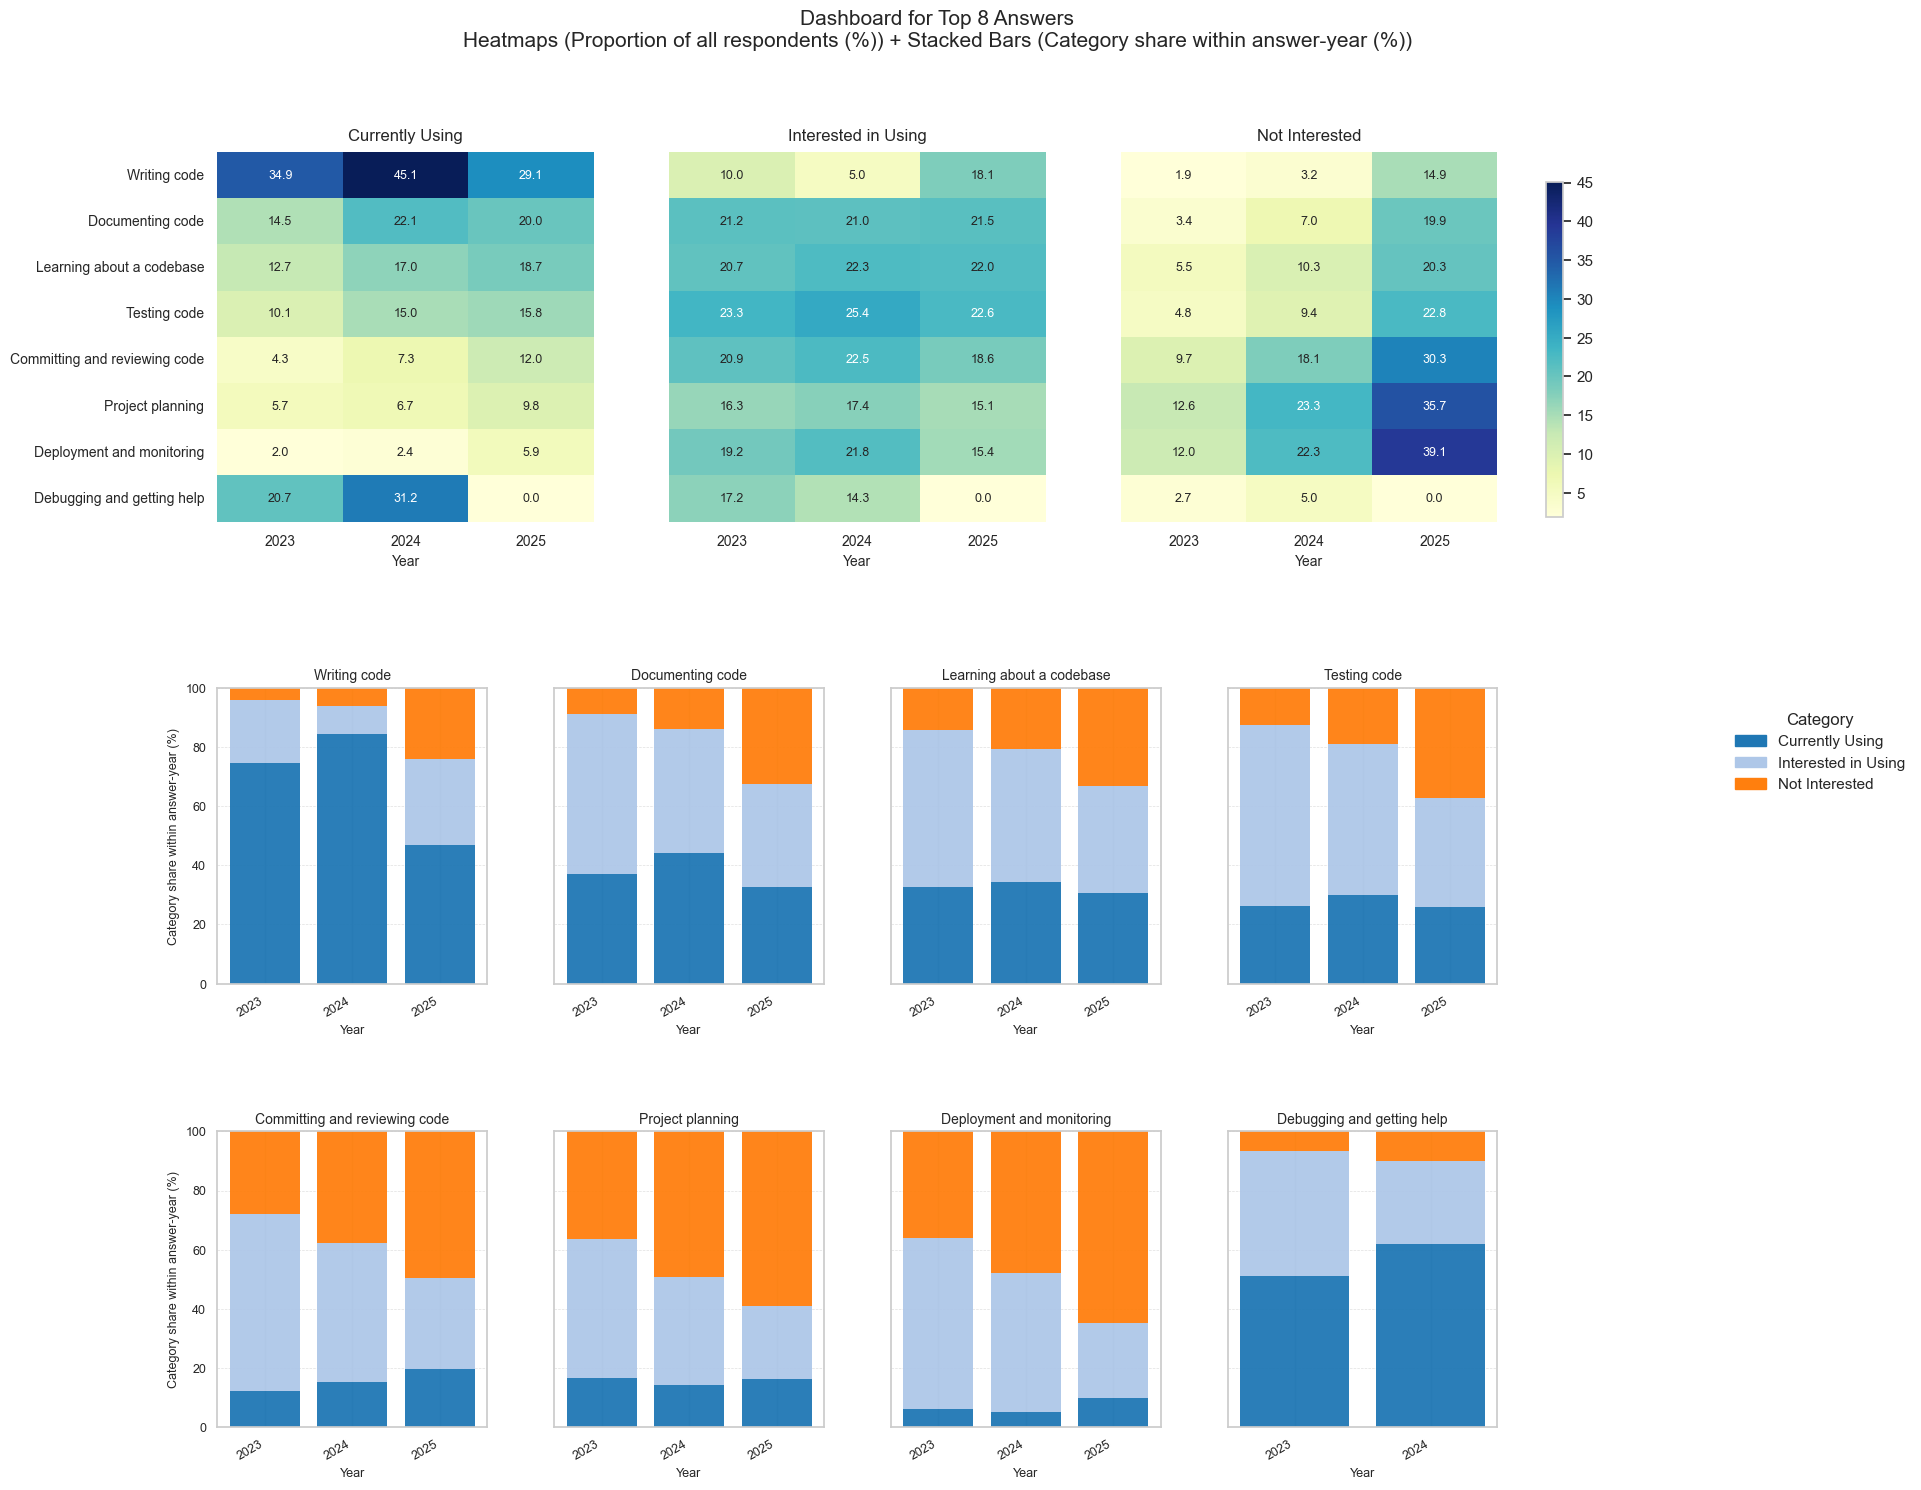

In [131]:
# Example pipeline (assuming you already computed trend_df, base_counts, categories)
plot_combined_dashboard(
    trend_df=trend_df,                 # long DF: ['Answer','Year','Category','Count']
    base_counts=base_counts,           # per-year totals for normalization (relative='year')
    categories=categories,             # list of category labels (3 in your case)

    top_n=8,                           # how many answers to display
    ensure_top_n_per_year=True,        # union of per-year top-N answers
    strict_top_n=True,                 # cap final selection back to exactly top_n

    relative_heatmap="year",           # heatmap values as % of respondents per year
    relative_bars="answer",            # bars are 100% stacks (share within each answer-year)
    bar_cols=4,                        # 4 bar subplots per row (8 → 2 rows)

    top_row_height=5.0,                # height (in) of the heatmaps row
    bar_row_height=5.0,                # height (in) per row of bar charts
    heatmap_width_per_cat=4.5,         # width (in) per heatmap column
    bar_width_per_col=4.0,             # width (in) per bar subplot

    font_scale=1.0,                    # global font scaling
    rotate_bar_xticks=30,              # rotate bar x-axis tick labels (deg)

    # Spacing tuned for your layout
    heatmap_wspace=0.2,                # horizontal gap between heatmaps
    bar_wspace=0.25,                   # horizontal gap between bar subplots
    bar_hspace=0.5,                    # vertical gap between bar rows
    gridspec_hspace=0.3,               # vertical gap between heatmaps block and bars block
    legend_right_pad=0.15,             # fraction of figure width reserved for right-side legend

    # Annotation and ticks
    annot_fontsize=9,                  # font size for heatmap cell annotations
    show_all_heatmap_y=False           # show y-ticks only on leftmost heatmap (saves space)
)

#### Question 1

**1.** In order to understand how to break into the field, we will look at the **CousinEducation** field.  Use the **schema** dataset to answer this question.  Write a function called **get_description** that takes the **schema dataframe** and the **column** as a string, and returns a string of the description for that column.

The question we have been focused on has been around how to break into the field.  Use your **get_description** function below to take a closer look at the **CousinEducation** column.

#### Question 2

**2.** Provide a pandas series of the different **CousinEducation** status values in the dataset.  Store this pandas series in **cous_ed_vals**.  If you are correct, you should see a bar chart of the proportion of individuals in each status.  If it looks terrible, and you get no information from it, then you followed directions.  However, we should clean this up!

We definitely need to clean this.  Above is an example of what happens when you do not clean your data. Below I am using the same code you saw in the earlier video to take a look at the data after it has been cleaned.

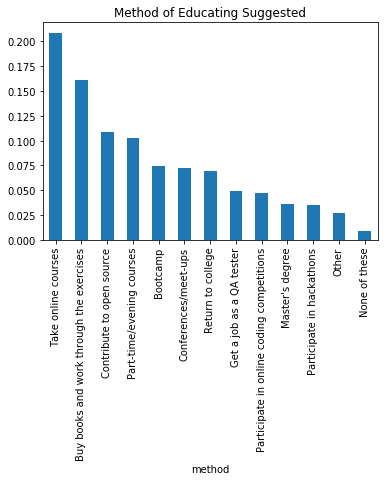

: 

In [ ]:
possible_vals = ["Take online courses", "Buy books and work through the exercises", 
                 "None of these", "Part-time/evening courses", "Return to college",
                 "Contribute to open source", "Conferences/meet-ups", "Bootcamp",
                 "Get a job as a QA tester", "Participate in online coding competitions",
                 "Master's degree", "Participate in hackathons", "Other"]

def clean_and_plot(df, title='Method of Educating Suggested', plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df['CousinEducation'].value_counts().reset_index()
    study.rename(columns={'index': 'method', 'CousinEducation': 'count'}, inplace=True)
    study_df = t.total_count(study, 'method', 'count', possible_vals)

    study_df.set_index('method', inplace=True)
    if plot:
        (study_df/study_df.sum()).plot(kind='bar', legend=None);
        plt.title(title);
        plt.show()
    props_study_df = study_df/study_df.sum()
    return props_study_df
    
props_df = clean_and_plot(df)

#### Question 3

**3.** I wonder if some of the individuals might have bias towards their own degrees.  Complete the function below that will apply to the elements of the **FormalEducation** column in **df**. 

In [ ]:
def higher_ed(formal_ed_str):
    '''
    INPUT
        formal_ed_str - a string of one of the values from the Formal Education column
    
    OUTPUT
        return 1 if the string is  in ("Master's degree", "Professional degree")
        return 0 otherwise
    
    '''
    if formal_ed_str in {"Master's degree", "Professional degree"}:
        value = 1
    else:
        value = 0
        
    return value
    

df["FormalEducation"].apply(higher_ed)[:5] #Test your function to assure it provides 1 and 0 values for the df

0    0
1    0
2    0
3    0
4    1
Name: FormalEducation, dtype: int64

: 

In [ ]:
df["FormalEducation"].value_counts()

Bachelor's degree                                                    8099
Master's degree                                                      4143
Some college/university study without earning a bachelor's degree    2869
Secondary school                                                     2227
Doctoral degree                                                       551
I prefer not to answer                                                409
Primary/elementary school                                             404
Professional degree                                                   255
I never completed any formal education                                145
Name: FormalEducation, dtype: int64

: 

In [ ]:
# Check your code here
df['HigherEd'] = df["FormalEducation"].apply(higher_ed)
higher_ed_perc = df['HigherEd'].mean()

Nice job!  That's right.  The percentage of individuals in these three groups is 0.2302376714480159.


: 

#### Question 4

**4.** Now we would like to find out if the proportion of individuals who completed one of these three programs feel differently than those that did not. Store a dataframe of only the individual's who had **HigherEd** equal to 1 in **ed_1**.  Similarly, store a dataframe of only the **HigherEd** equal to 0 values in **ed_0**.

Notice, you have already created the **HigherEd** column using the check code portion above, so here you only need to subset the dataframe using this newly created column.

In [ ]:
ed_1 = df[df['HigherEd']==1] # Subset df to only those with HigherEd of 1
ed_0 = df[df['HigherEd']==0] # Subset df to only those with HigherEd of 0


print(ed_1['HigherEd'][:5]) #Assure it looks like what you would expect
print(ed_0['HigherEd'][:5]) #Assure it looks like what you would expect

4     1
6     1
7     1
9     1
14    1
Name: HigherEd, dtype: int64
0    0
1    0
2    0
3    0
5    0
Name: HigherEd, dtype: int64


: 

In [ ]:
#Check your subset is correct - you should get a plot that was created using pandas styling
#which you can learn more about here: https://pandas.pydata.org/pandas-docs/stable/style.html

ed_1_perc = clean_and_plot(ed_1, 'Higher Formal Education', plot=False)
ed_0_perc = clean_and_plot(ed_0, 'Max of Bachelors Higher Ed', plot=False)

comp_df = pd.merge(ed_1_perc, ed_0_perc, left_index=True, right_index=True)
comp_df.columns = ['ed_1_perc', 'ed_0_perc']
comp_df['Diff_HigherEd_Vals'] = comp_df['ed_1_perc'] - comp_df['ed_0_perc']
comp_df.style.bar(subset=['Diff_HigherEd_Vals'], align='mid', color=['#d65f5f', '#5fba7d'])

,ed_1_perc,ed_0_perc,Diff_HigherEd_Vals
method,,,
Take online courses,0.205361,0.21009,-0.00472961
Buy books and work through the exercises,0.163579,0.160257,0.00332183
Contribute to open source,0.106031,0.110053,-0.00402243
Part-time/evening courses,0.101498,0.103005,-0.00150699
Bootcamp,0.0731179,0.0740695,-0.000951639
Return to college,0.0691762,0.0691233,5.29081e-05
Conferences/meet-ups,0.0670083,0.0740695,-0.00706122
Master's degree,0.0557745,0.0302337,0.0255408
Get a job as a QA tester,0.0508475,0.0481019,0.00274557


: 

#### Question 5

**5.** What can you conclude from the above plot?  Change the dictionary to mark **True** for the keys of any statements you can conclude, and **False** for any of the statements you cannot conclude.

In [ ]:
sol = {'Everyone should get a higher level of formal education': False, 
       'Regardless of formal education, online courses are the top suggested form of education': True,
       'There is less than a 1% difference between suggestions of the two groups for all forms of education': False,
       'Those with higher formal education suggest it more than those who do not have it': True}


Nice job that looks right!


: 

This concludes another look at the way we could compare education methods by those currently writing code in industry.

: 